A linear predictors is a linear function (linear combination) of a set of coefficients and explanatory variables (independent variables), whose value is used to predict the outcome of a dependent variable.

Many learning algorithms rely on linear predictors. Moreover, linear predictors are intuitive, easy to inerpret and fit the data reasonably well in many natural learning problems

Linera predictors are besd on the class of affine functions

$$ L_d = \{\mathbf x \mapsto \langle\mathbf w, \mathbf x\rangle + b:\mathbf w \in \mathbb R^d, b \in \mathbb R\} $$

Each function $h_{\mathbf w,b}$ is parametrized by a vector $\mathbf w$ that define a linear transformation and a scalar $b$ that define a translation.
Usually the term $b$, called *bias* is incorporated into $\mathbf w$ as an extra coordinate, adding also an extra coordinate with value 1 to all $\mathbf x \in \mathcal X$

$$ \mathbf w' =\begin{pmatrix}b, w_1, \ldots, w_d\end{pmatrix} \qquad \mathbf x' = \begin{pmatrix}1, x_1, \ldots, x_d\end{pmatrix}$$

## Halfspaces

A function $h_{\mathbf w,b}$ defines an hyperplane in the space $\mathbb R$ that divide this into two subsapces called *half-spaces*. The hypothesis class of halfspaces is designed for binary classification problems, namely $\mathcal X=\mathbb R^d$ and $\mathcal Y =\{-1,+1\}$. The class of half-spaces is defined as follows:

$$ HS_d = \text{sign}\circ L_d = \{\mathbf x \mapsto \text{sign}(h_{\mathbf w,b}(\mathbf x)) : h_{\mathbf w,b} \in L_d\}$$

Consider the 2-dimensional case. Each hypothesis define an hyperplane that is perpendicular to the vector $\mathbf w$ and separates the space into two sub-spaces:

- the points *above* the hyperplane (that share an acute angle with $\mathbf w$) are labeled positively
- the points *below* the hyperplane (that share an obtuse angle with $\mathbf w$) are labeled negatively

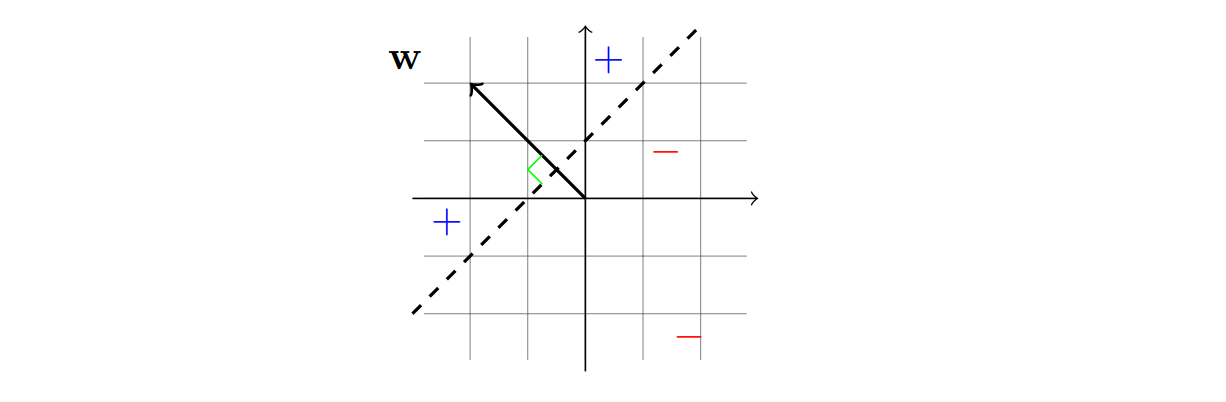

In the condition of **realizability assumption** (namely the points of the two classes are linearly separable), the ERM problem for halfspaces can be expressed as a linear program, that is an optimization problem of a *linear function* under *linear constraints*.

Let $S = \{(\mathbf x_i, y_i)\}_{i=1}^m$ be a training set of size $m$. From the realizability assumption follows that an ERM predictor should have zero errors on the training set. Or equivalently that exists at least a vector $\mathbf w^*$ such that:

$$ \text{sign}(\langle\mathbf w^*, \mathbf x_i\rangle) = y_i,\qquad \forall i = 1, \ldots, m$$

Considering the closest point to the hyperplane $\gamma = \min_i(y_i\langle\mathbf w^*, \mathbf x_i\rangle)$ we can define the vector $\mathbf{\bar w} = \frac{\mathbf w^*}{\gamma} $. Therefore foreach $i$:

$$ y_i\langle\mathbf{\bar w}, \mathbf x_i\rangle = \frac{1}{\gamma}y_i\langle\mathbf w^*, \mathbf x_i\rangle = \frac{y_i\langle\mathbf w^*, \mathbf x_i\rangle}{\min_i(y_i\langle\mathbf w^*, \mathbf x_i\rangle)} \ge 1 $$

Letting $A\in\mathbb R ^{m\times d}$ be the matrix whose elements are defined as $A_{i,j} = y_ix_{i,j}$ and letting $\mathbf v = \begin{pmatrix} 1, 1, \ldots,1\end{pmatrix}\in\mathbb R^m$, the equation above can be rewritten as a linear program:

$$ A\mathbf w \ge \mathbf v $$

Note that since all the vectors that satisfy this constraint are euqally good candidates, we can set a dummy objective $u = \begin{pmatrix} 0,0,\ldots,0\end{pmatrix}\in\mathbb R^d$

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

separating_line = lambda x: 2*x + 5

x_pos = np.array([(x - 10*np.random.rand(), separating_line(x) + 10*np.random.rand()) for x in np.random.randint(-5, 5, 20)])
x_neg = np.array([(x + 10*np.random.rand(), separating_line(x) - 10*np.random.rand())for x in np.random.randint(-5, 5, 20)])

X = np.vstack((x_pos, x_neg))
y = np.hstack((np.ones(len(x_pos)), -1 * np.ones(len(x_neg))))
# plt.scatter(x_pos[:,0], x_pos[:,1], 'r')
# plt.scatter(x_neg[:,0], x_neg[:,1], 'b')
# plt.show()


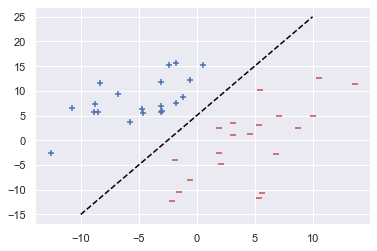

In [51]:
plt.scatter(x_pos[:,0], x_pos[:,1], c='b', marker='+')
plt.scatter(x_neg[:,0], x_neg[:,1], c='r', marker='_')
plt.plot([-10,10], [separating_line(-10), separating_line(10)],  linestyle='--', color ='black')

In [83]:
from scipy.optimize import linprog

u = np.zeros(2)
A = X *y[:,np.newaxis]
v = np.ones(len(X))

res = linprog(u, A, v)

In [84]:
w = res.x

In [105]:
y_pred = np.sign(w @X.T )

In [94]:
y_pred

array([[ 1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,
         1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1., -1.,
         1.]])

In [99]:
y_pred = [np.sign(w.T @ X[i]) for i in range(len(X))]

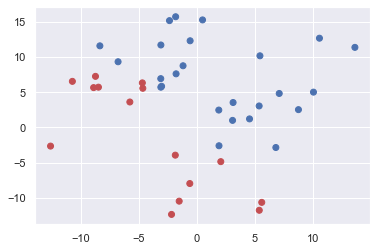

In [106]:
colors = ['b' if y == 1.0 else 'r' for y in y_pred ]
plt.scatter(X[:,0], X[:,1], c= colors)